In [47]:
import os
import shutil
import glob
import uuid

import tensorflow as tf
from tqdm.notebook import tqdm
from sklearn.utils import shuffle
import pandas as pd
import cv2
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
%matplotlib inline 

# [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/)

2371 cat images and 4978 dog images

**Download data and move to `data` directory**

In [ ]:
! curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
! tar zxvf images.tar.gz
! curl -O http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
! tar zxvf annotations.tar.gz

In [12]:
! mkdir data
! cd data && mkdir Oxford_IIIT_Pet_Dataset

In [13]:
! mv images/ data/Oxford_IIIT_Pet_Dataset/images
! mv annotations/ data/Oxford_IIIT_Pet_Dataset/annotations

In [37]:
! cat ./data/Oxford_IIIT_Pet_Dataset/annotations/README

OXFORD-IIIT PET Dataset
-----------------------
Omkar M Parkhi, Andrea Vedaldi, Andrew Zisserman and C. V. Jawahar

We have created a 37 category pet dataset with roughly 200 images for each class. 
The images have a large variations in scale, pose and lighting. All images have an 
associated ground truth annotation of breed, head ROI, and pixel
level trimap segmentation.

Contents:
--------
trimaps/ 	Trimap annotations for every image in the dataset
		Pixel Annotations: 1: Foreground 2:Background 3: Not classified
xmls/		Head bounding box annotations in PASCAL VOC Format

list.txt	Combined list of all images in the dataset
		Each entry in the file is of following nature:
		Image CLASS-ID SPECIES BREED ID
		ID: 1:37 Class ids
		SPECIES: 1:Cat 2:Dog
		BREED ID: 1-25:Cat 1:12:Dog
		All images with 1st letter as captial are cat images while
		images with small first letter are dog images.
trainval.txt	Files describing splits used in the paper.However,
test.txt	you are encouraged to try ra

**Read all data into dataframe**

In [48]:
# Check the path before running cells
DATA_DIR = "data/Oxford_IIIT_Pet_Dataset"

# Read the `list.txt` to find the labels of images
with open(os.path.join(DATA_DIR, "annotations", "list.txt")) as f:
    text = f.readlines()

# Clean the lines then convert to pandas dataframe
text = [line.strip().split(' ') for line in text[6:]]
data = pd.DataFrame(text, columns=["image_name", "id", "species", "breed"])

# The species label of cat is 1
print("Number of images \nCat: %s \nDog: %s" % (len(data[data.species == '1']), len(data[data.species != '1'])))

Number of images 
Cat: 2371 
Dog: 4978


**Only cat**

In [49]:
data = data[data.species == '1']

**See data**
- 1: foreground 
- 2: background
- 3: not classified

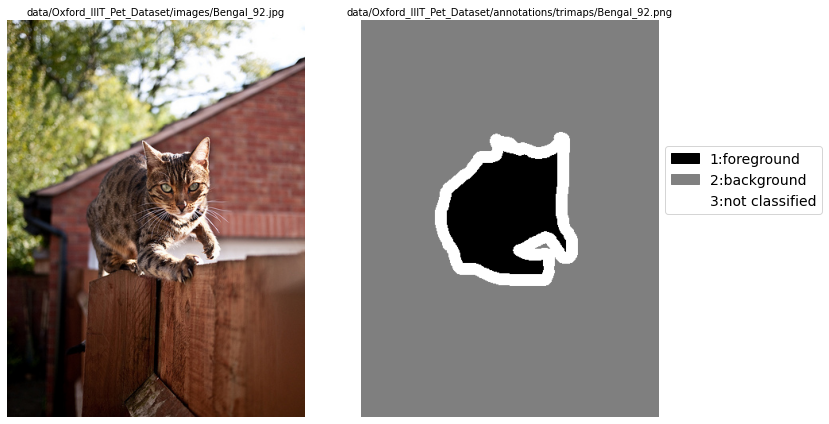

In [132]:
random_image_name = np.random.choice(data[data.species == '1'].image_name)

plt.figure(figsize=(12, 6))
plt.subplot(121)
img_path = os.path.join(DATA_DIR, "images", random_image_name + ".jpg")
plt.title(img_path, fontsize=10)
img = cv2.imread(img_path)
plt.imshow(img[:,:,::-1])
plt.axis('off')

plt.subplot(122)
mask_path = os.path.join(DATA_DIR, "annotations", "trimaps", random_image_name + ".png")
plt.title(mask_path, fontsize=10)
mask = cv2.imread(mask_path)
plt.imshow(tf.keras.preprocessing.image.array_to_img(mask))
plt.axis('off')

t = 1 ## alpha value
cmap = {1:[0.0,0.0,0.0,t],2:[0.5,0.5,0.5,t],3:[1.0,1.0,1.0,t]}
labels = {1:'1:foreground',2:'2:background',3:'3:not classified'}
patches =[mpatches.Patch(color=cmap[i],label=labels[i]) for i in cmap]
plt.legend(handles=patches, fontsize=14, bbox_to_anchor=(1, 0.7), loc='upper left')

plt.tight_layout()
plt.show()

**Shuffle the data**

In [165]:
data = shuffle(data)

**Split train and val set**

In [166]:
val_split = 0.2
split_index = int(len(data)*(1-val_split))

train_dir = os.path.join("data", "train_image", "class_0")
train_mask_dir = os.path.join("data", "train_mask", "class_0")

val_dir = os.path.join("data", "val_image", "class_0")
val_mask_dir = os.path.join("data", "val_mask", "class_0")

**Copy images and masks**

In [181]:
for dest_dir in [train_dir, train_mask_dir, val_dir, val_mask_dir]:
    if os.path.exists(dest_dir):
        shutil.rmtree(dest_dir)
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)

In [182]:
for image_name in tqdm(data[:split_index].image_name):
    src = os.path.join(DATA_DIR, "images", image_name + ".jpg")
    dest = os.path.join(train_dir, image_name + ".jpg")
    shutil.copyfile(src, dest)

In [183]:
for image_name in tqdm(data[:split_index].image_name):
    src = os.path.join(DATA_DIR, "annotations", "trimaps", image_name + ".png")
    dest = os.path.join(train_mask_dir, image_name + ".png")
    img = cv2.imread(src)
    # Convert to binary mask contains only 0's and 1's by replace 'not classified' to 'foreground'
    img = img - 1
    img[img==2] = 0
    img = 1 - img
    cv2.imwrite(dest, img)

In [184]:
for image_name in tqdm(data[split_index:].image_name):
    src = os.path.join(DATA_DIR, "images", image_name + ".jpg")
    dest = os.path.join(val_dir, image_name + ".jpg")
    shutil.copyfile(src, dest)

In [185]:
for image_name in tqdm(data[split_index:].image_name):
    src = os.path.join(DATA_DIR, "annotations", "trimaps", image_name + ".png")
    dest = os.path.join(val_mask_dir, image_name + ".png")
    img = cv2.imread(src)
    # Convert to binary mask contains only 0's and 1's by replace 'not classified' to 'foreground'
    img = img - 1
    img[img==2] = 0
    img = 1 - img
    cv2.imwrite(dest, img)

**Check Data**

In [186]:
def see_image_and_mask(image_dir, mask_dir):
    random_image_name = np.random.choice(glob.glob(os.path.join(image_dir, '*'))).split('/')[-1].replace(".jpg", '')
    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plt.title(os.path.join(image_dir, random_image_name + ".jpg"))
    img = cv2.imread(os.path.join(image_dir, random_image_name + ".jpg"))
    plt.imshow(img[:,:,::-1])
    plt.axis('off')
    
    plt.subplot(122)
    mask_path = os.path.join(mask_dir, random_image_name + ".png")
    plt.title(mask_path, fontsize=10)
    mask = cv2.imread(mask_path)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(mask))
    plt.axis('off')
    
    t = 1
    cmap = {0:[0.0,0.0,0.0,t], 1:[1.0,1.0,1.0,t]}
    labels = {0: '0:background', 1:'1:foreground'}
    patches =[mpatches.Patch(color=cmap[i],label=labels[i]) for i in cmap]
    plt.legend(handles=patches, fontsize=14, bbox_to_anchor=(1, 0.7), loc='upper left')

    plt.tight_layout()
    plt.show()

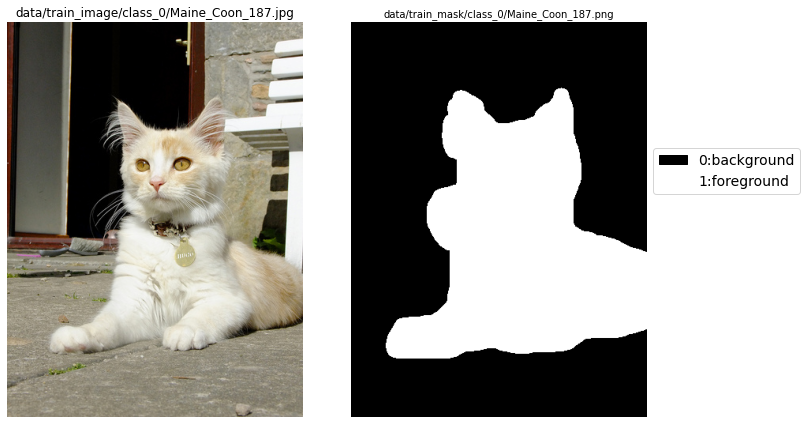

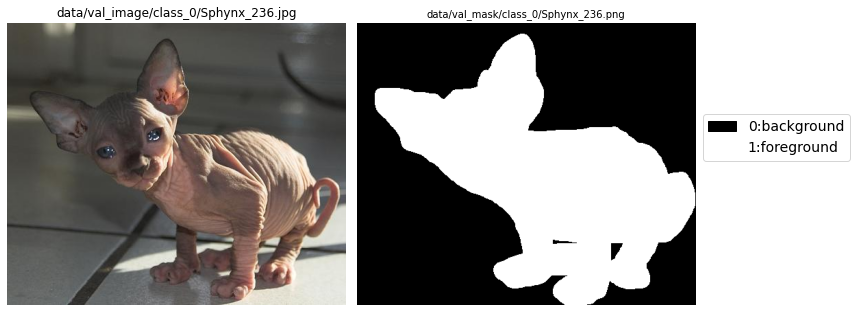

In [193]:
see_image_and_mask(train_dir, train_mask_dir)
see_image_and_mask(val_dir, val_mask_dir)